Code can be found in the repository: https://github.com/ttanyay/data_analysis_3/tree/main/assignment2

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import regex as re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *
import ast
from collections import Counter
from geopy.distance import geodesic
from shapely.geometry import Point
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import patsy

warnings.filterwarnings("ignore")

c:\Users\yakus\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# file_path_q2 = r"D:/save/Edu/CEU/Prediction with ML for Economists/Assignment 2/input/csv_gzv/listings_mallorca_q2.csv"
data_initial = pd.read_csv('https://data.insideairbnb.com/spain/islas-baleares/mallorca/2024-06-19/data/listings.csv.gz', compression='gzip') #, index_col=0)
data = data_initial.copy()
print(data.shape)
data.head(1)

(17215, 75)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,106833,https://www.airbnb.com/rooms/106833,20240619031546,2024-06-19,city scrape,Villa with a big pool in Mallorca,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,551974,...,4.91,4.48,4.7,ET/1961,f,1,1,0,0,0.16


Checking columns and the size of dataframe

In [3]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

# Part 1.1. Data Preparation

Checking missing variables

In [4]:
def missing_value_summary(df):
    columns_with_nans = [col for col in df.columns if df[col].isnull().any()]
    missing_counts = df[columns_with_nans].isnull().sum().sort_values(ascending=False)
    return missing_counts
missing_value_summary(data)

neighbourhood_group_cleansed    17215
calendar_updated                17215
host_neighbourhood              13809
neighbourhood                   10550
neighborhood_overview           10550
host_about                       6038
license                          5716
host_location                    4554
review_scores_cleanliness        4350
review_scores_value              4349
review_scores_accuracy           4349
review_scores_location           4349
review_scores_communication      4349
review_scores_checkin            4349
last_review                      4338
first_review                     4338
reviews_per_month                4338
review_scores_rating             4338
price                             655
host_response_rate                636
host_response_time                636
description                       584
beds                              576
bathrooms                         570
host_acceptance_rate              559
host_is_superhost                 177
has_availabi

Preparing traget variable 'price'. Checking currency: if all unique price patterns contain a dollar sign

In [5]:
unique_price_patterns = data["price"].dropna().unique()
all_contain_dollar = all('$' in price for price in unique_price_patterns)
# print(all_contain_dollar) # True
data["price"] = data["price"].str.replace("$", "").str.replace(",", "").astype("float")

data = data[~data.price.isna()].reset_index(drop = True)
print(data.price.describe())
data.shape

count    16560.000000
mean       323.146860
std        528.440177
min         10.000000
25%        148.000000
50%        220.000000
75%        350.000000
max      25000.000000
Name: price, dtype: float64


(16560, 75)

## Listing and host infromation

Change text information columns to indicators that show that there is infromation.

In [6]:
text_columns_to_convert = ['description', 'neighborhood_overview', 'host_about']

for col in text_columns_to_convert:
    binary_col_name = f"has_{col}"
    data[binary_col_name] = data[col].notnull().astype(int)

data.drop(columns=text_columns_to_convert, inplace=True)
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,picture_url,host_id,host_url,host_name,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,has_description,has_neighborhood_overview,has_host_about
0,106833,https://www.airbnb.com/rooms/106833,20240619031546,2024-06-19,city scrape,Villa with a big pool in Mallorca,https://a0.muscache.com/pictures/miso/Hosting-...,551974,https://www.airbnb.com/users/show/551974,Xisco,...,ET/1961,f,1,1,0,0,0.16,0,0,1
1,159218,https://www.airbnb.com/rooms/159218,20240619031546,2024-06-19,city scrape,Farmhouse in Nature -ET-3025,https://a0.muscache.com/pictures/22458820/5aad...,763897,https://www.airbnb.com/users/show/763897,Gabriel,...,ET-3025 Conselleria de Turismo de Baleares,f,1,1,0,0,2.37,1,1,1
2,69998,https://www.airbnb.com/rooms/69998,20240619031546,2024-06-19,city scrape,COZY HIDEAWAY LOFT... MI AMOR...,https://a0.muscache.com/pictures/6d4007c1-f223...,353156,https://www.airbnb.com/users/show/353156,Lor,...,NaN,t,2,2,0,0,1.74,1,1,1
3,166820,https://www.airbnb.com/rooms/166820,20240619031546,2024-06-19,city scrape,Guest House with Great sea views - Principal Room,https://a0.muscache.com/pictures/1059096/b3b02...,794829,https://www.airbnb.com/users/show/794829,Toni,...,NaN,t,4,0,4,0,1.90,0,0,1
4,168697,https://www.airbnb.com/rooms/168697,20240619031546,2024-06-19,city scrape,Design Self-catering home in Majorca center,https://a0.muscache.com/pictures/miso/Hosting-...,804167,https://www.airbnb.com/users/show/804167,Maria,...,NaN,t,3,3,0,0,0.48,1,1,1


In [7]:
li_dummy_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
data = pd.get_dummies(data, columns = li_dummy_columns, drop_first=True)

In [8]:
data['host_since'] = pd.to_datetime(data['host_since'], format='%Y-%m-%d')

data["days_since"] = pd.to_datetime(
    data["calendar_last_scraped"], format="%Y-%m-%d"
) - pd.to_datetime(data["first_review"], format="%Y-%m-%d")

# Previous row creates a timedelta object in each row. Get the elapsed number of days like:
data["days_since"] = [x.days for x in data["days_since"]]
data["days_since"].describe()

# data['host_since'] = pd.to_datetime(data['host_since'], errors='coerce')
# data['host_since_year'] = data['host_since'].dt.year
# data = data.drop(columns=['host_since'])

count    12481.000000
mean      1344.731913
std       1007.603995
min          0.000000
25%        442.000000
50%       1078.000000
75%       2116.000000
max       4699.000000
Name: days_since, dtype: float64

In [9]:
data["host_response_rate"] = data["host_response_rate"].str.rstrip('%').astype("float") / 100
data["host_acceptance_rate"] = data["host_acceptance_rate"].str.rstrip('%').astype("float") / 100

Extract values from the host_verifications column

In [10]:
# convert stringified lists into actual lists
df_tmp = data.copy()
df_tmp['host_verifications'] = df_tmp['host_verifications'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else [])
)

# unique verification methods
all_verifications = set()
for items in df_tmp['host_verifications']:
    all_verifications.update(items)

# dummy columns for each verification method
for method in all_verifications:
    df_tmp[method] = df_tmp['host_verifications'].apply(lambda x: int(method in x))

df_tmp.drop(columns=['host_verifications'], inplace=True)
data = df_tmp
data.shape

(16560, 78)

# Property type and room type

In [ ]:
# room type variables
data["room_type"] = data["room_type"].astype("category")

# simplified version for modeling
data["room_type2"] = (
    data["room_type"]
    .replace({
        "Entire home/apt": "Entire/Apt",
        "Private room": "Private",
        "Shared room": "Shared",
    })
    .astype("category")
)
data.shape

(16560, 79)

In [12]:
data["property_type"].value_counts()

Villa            5071
House            4856
Apartment        3625
Private           900
Cottage           769
Chalet            406
Hotel             372
Other             141
Unique            136
Vacation Home      89
Loft               63
Guesthouse         47
Bungalow           39
Guest Suite        23
Cabin              12
Shared             11
Name: property_type, dtype: int64

In [13]:
data["room_type2"].value_counts()

Entire/Apt    15263
Private        1217
Hotel room       69
Shared           11
Name: room_type2, dtype: int64

In [14]:
room_type_map = {
    "Entire home/apt": "rt_entire",
    "Private room": "rt_private",
    "Hotel room": "rt_hotel",
    "Shared room": "rt_shared"
}

# Map room_type to simplified labels
data["room_type_clean"] = data["room_type"].map(room_type_map)

# Create dummy columns with those clean names
room_dummies = pd.get_dummies(data["room_type_clean"])

# Merge with original data
data = pd.concat([data, room_dummies], axis=1)

# Distance to Palma Center

Compute the distance from each airbnb to Palma City Center and also to the closest coast line.

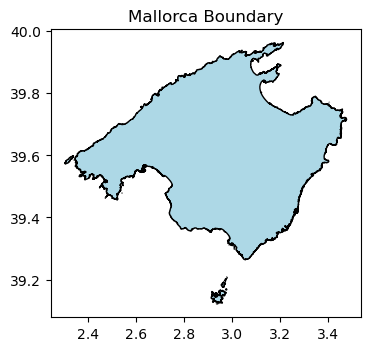

In [15]:
# Mallorca polygon
mallorca = ox.geocode_to_gdf("Mallorca, Spain")

fig, ax = plt.subplots(figsize=(4, 4))
mallorca.plot(edgecolor='black', facecolor='lightblue', ax=ax)
ax.set_title("Mallorca Boundary")
plt.show()


In [16]:
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
data = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

data = data.to_crs(epsg=3857)
mallorca = mallorca.to_crs(epsg=3857)
mallorca_boundary = mallorca.geometry.iloc[0].boundary
data['dist_to_coast_km'] = data.geometry.distance(mallorca_boundary) / 1000  # meters to km
data['dist_to_coast_km'].describe()

count    16560.000000
mean         5.699267
std          7.288251
min          0.000002
25%          0.322199
50%          1.906211
75%          9.377459
max         30.643894
Name: dist_to_coast_km, dtype: float64

In [17]:
# Coordinates of Palma city center
palma_coords = (39.5696, 2.6502)

data['dist_to_palma'] = data.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), palma_coords).kilometers,
    axis=1
)

data = data.drop(columns=['latitude', 'longitude'])

data['dist_to_palma'].describe()

count    16560.000000
mean        38.916256
std         17.744408
min          0.005617
25%         25.679057
50%         45.782244
75%         51.578499
max         72.472293
Name: dist_to_palma, dtype: float64

## Amenities

Extract the top 50 common values from the amenities column

In [18]:
import ast
from collections import Counter
import re

df_tmp = data.copy()

# convert stringified lists into actual lists
for col in ['amenities']:
    df_tmp[col] = df_tmp[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else [])
    )

# count frequency of all values across amenities
counter = Counter()
for col in ['amenities']:
    for items in df_tmp[col]:
        counter.update(items)

# top 50 most common values
top_values = set([item for item, _ in counter.most_common(50)])

# function to clean names: lowercase, replace spaces with underscores, remove special chars
def clean_name(name):
    name = name.lower().strip()
    name = re.sub(r"[^\w\s]", "", name)  # remove punctuation
    name = re.sub(r"\s+", "_", name)     # replace spaces with underscores
    return name

# dummy columns for each of the top 50 values, using cleaned names
for value in top_values:
    cleaned_col_name = clean_name(value)
    df_tmp[cleaned_col_name] = df_tmp[['amenities']].apply(
        lambda row: int(any(value in entry for entry in row)), axis=1
    )

# drop original amenities column
df_tmp.drop(columns=['amenities'], inplace=True)
data = df_tmp
data.shape


(16560, 134)

## Missing values

In [19]:
missing_value_summary(data)

neighbourhood_group_cleansed    16560
calendar_updated                16560
host_neighbourhood              13325
neighbourhood                   10144
license                          5424
host_location                    4332
review_scores_value              4090
review_scores_location           4090
review_scores_communication      4090
review_scores_checkin            4090
review_scores_cleanliness        4090
review_scores_accuracy           4090
review_scores_rating             4079
reviews_per_month                4079
days_since                       4079
last_review                      4079
first_review                     4079
host_response_time                598
host_response_rate                598
host_acceptance_rate              529
has_availability                   48
bathrooms_text                     15
beds                               12
bathrooms                           6
bedrooms                            4
dtype: int64

In [20]:
missing_columns = data.columns[data.isnull().any()]
data[missing_columns].dtypes

host_location                    object
host_response_time               object
host_response_rate              float64
host_acceptance_rate            float64
host_neighbourhood               object
neighbourhood                    object
neighbourhood_group_cleansed    float64
bathrooms                       float64
bathrooms_text                   object
bedrooms                        float64
beds                            float64
calendar_updated                float64
has_availability                 object
first_review                     object
last_review                      object
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64
review_scores_location          float64
review_scores_value             float64
license                          object
reviews_per_month               float64
days_since                      float64


Drop the columns that are not relevant for analysis

In [21]:
data0 = data.copy()

In [22]:
li_drop_columns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'license', 'source', 'name',
    'host_id', 'host_url', 'picture_url', 'host_location', 'host_thumbnail_url', 
    'host_picture_url', 'host_neighbourhood', 'host_name', 'host_response_time',
    'neighbourhood', 'property_type', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
    'bathrooms_text', 'calendar_updated', 'has_availability', 'geometry', 'calendar_last_scraped',
    'first_review', 'last_review', 'room_type2', 'room_type_clean', 'host_since', 
    'availability_30', 'availability_60', 'availability_365', "number_of_reviews", "number_of_reviews_ltm", 
    "number_of_reviews_l30d"]

data = data.drop(columns = li_drop_columns)
data.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,dedicated_workspace,drying_rack_for_clothing,cooking_basics,freezer,stove,self_checkin,toaster,backyard,washer,microwave
0,1.0,0.90,1,1,4,1.0,2.0,4.0,200.0,5,...,0,0,0,0,0,0,0,0,1,0
1,1.0,1.00,1,1,3,1.0,1.0,2.0,150.0,4,...,1,1,1,1,0,0,1,0,0,1
2,1.0,1.00,2,5,2,1.0,1.0,1.0,99.0,32,...,1,1,1,1,1,0,1,0,1,1
3,1.0,1.00,4,5,2,1.0,1.0,1.0,76.0,1,...,1,0,1,0,1,0,0,1,0,1
4,1.0,0.93,3,11,2,1.0,1.0,1.0,80.0,7,...,1,1,1,1,0,1,1,0,0,1


In [23]:
missing_value_summary(data)

review_scores_accuracy         4090
review_scores_cleanliness      4090
review_scores_checkin          4090
review_scores_communication    4090
review_scores_location         4090
review_scores_value            4090
review_scores_rating           4079
reviews_per_month              4079
days_since                     4079
host_response_rate              598
host_acceptance_rate            529
beds                             12
bathrooms                         6
bedrooms                          4
dtype: int64

Drop rows with missing values in specific columns with systematic number of NAs

In [24]:
cols_to_check = [
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'review_scores_rating', 'reviews_per_month'
]

data = data.dropna(subset=cols_to_check).reset_index(drop=True)
data.shape


(12470, 97)

Drop rows where selected columns have just a few missing values (less than 5%)

In [25]:
na_ratios = data.isnull().mean()
minor_missing = na_ratios[(na_ratios > 0) & (na_ratios < 0.05)].index
data.dropna(subset=minor_missing, inplace=True)

In [26]:
data['price'].describe()

count    12036.000000
mean       287.445331
std        432.187439
min         10.000000
25%        140.000000
50%        207.000000
75%        323.000000
max      12000.000000
Name: price, dtype: float64

Remove the top 10% most expensive listings to reduce the impact of extreme values on the model

In [27]:
price_cutoff = data["price"].quantile(0.90)
data = data[data["price"] <= price_cutoff].reset_index(drop=True)
data.shape

(10834, 97)

In [28]:
data['price'].describe()

count    10834.000000
mean       213.845856
std        106.753129
min         10.000000
25%        133.000000
50%        193.000000
75%        278.750000
max        514.000000
Name: price, dtype: float64

Simple imputing with replacing missing values with mode

In [29]:
for col in data.columns:
    if data[col].isnull().any():
        mode_value = data[col].mode()[0]
        data[col].fillna(mode_value, inplace=True)

# Optional: reset index after row drops
data.reset_index(drop=True, inplace=True)

# Preview shape
data.shape

(10834, 97)

# Part 1.2. Predictive models

In [30]:
data_work = data.copy()

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split target and features
y = data["price"].copy()
X = data.drop(columns=["price"]).copy()

# Convert binary features to categorical (for boosting models)
binary_features = [col for col in X.columns if X[col].nunique() == 2]
for col in binary_features:
    X[col] = X[col].astype("category")

# Standardized version (for OLS, LASSO, etc.)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
    X_scaled, y, test_size=0.2, random_state=30032025
)

# Raw version (for tree-based models)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=30032025
)


In [32]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# import time

# # OLS Model
# ols = LinearRegression()

# start = time.time()

# ols.fit(X_train_linear, y_train_linear)

# end = time.time()
# print(f"Overall time {end - start} sec")

# ols_prediction = ols.predict(X_test_linear)

# np.sqrt(mean_squared_error(y_test_linear, ols_prediction))

In [33]:
# Basic listing features
basic_features = [
    "accommodates", "bedrooms", "beds", "bathrooms",
    "rt_entire", "rt_private", "rt_shared", "rt_hotel"
]

# Review-related features
review_features = [
    "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
    "review_scores_checkin", "review_scores_communication", "review_scores_location",
    "review_scores_value", "reviews_per_month"
    # "number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d",
]

# Location-based features
location_features = [
    "dist_to_palma", "dist_to_coast_km", "has_neighborhood_overview"
]

# Host-related features
host_features = [
    "host_response_rate", "host_acceptance_rate", "host_listings_count",
    "host_total_listings_count", "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
    "host_is_superhost_t", "host_has_profile_pic_t", "host_identity_verified_t",
    "instant_bookable_t", "work_email", "email", "phone", 
    "has_description", "has_host_about"
]

# Availability and night restriction features
availability_features = ["availability_90", # "availability_60", "availability_90", "availability_365",
    "minimum_nights", "maximum_nights", "minimum_minimum_nights", "maximum_minimum_nights",
    "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm", "days_since"
]


# Amenity features — grouped by 0/1 presence
amenity_features = [
        'self_checkin', 'pool', 'hair_dryer', 'smoke_alarm',
       'wifi', 'hangers', 'patio_or_balcony', 'backyard',
       'dedicated_workspace', 'heating', 'freezer', 'refrigerator', 'bathtub',
       'private_entrance', 'iron', 'air_conditioning', 'coffee_maker',
       'bbq_grill', 'stove', 'extra_pillows_and_blankets', 'tv',
       'drying_rack_for_clothing', 'hot_water', 'dishwasher', 'first_aid_kit',
       'garden_view', 'toaster', 'free_parking_on_premises',
       'outdoor_dining_area', 'hot_water_kettle', 'cooking_basics', 'lockbox',
       'oven', 'mountain_view', 'free_street_parking', 'microwave',
       'dishes_and_silverware', 'bed_linens', 'private_patio_or_balcony',
       'fire_extinguisher', 'high_chair', 'washer', 'outdoor_furniture',
       'wine_glasses', 'long_term_stays_allowed', 'dining_table', 'crib',
       'roomdarkening_shades', 'kitchen', 'essentials'
]


Create esimation equations

In [34]:
modelv1 = "~ accommodates"
modelv2 = "~ " + " + ".join(basic_features)
modelv3 = "~ " + " + ".join(basic_features + review_features)
modelv4 = "~ " + " + ".join(basic_features + review_features + location_features)
modelv5 = "~ " + " + ".join(basic_features + review_features + location_features + host_features)
modelv6 = "~ " + " + ".join(basic_features + review_features + location_features + host_features + availability_features)
modelv7 = "~ " + " + ".join(basic_features + review_features + location_features + host_features + availability_features + amenity_features)
model_equations = [modelv1, modelv2, modelv3, modelv4, modelv5, modelv6, modelv7]


## Create separate holdout set

In [35]:
sample_size = round(0.2 * data.shape[0]) - 1

 Set the random number generator: It will make results reproducable

In [36]:
np.random.seed(30032025)

In [37]:
from sklearn.model_selection import train_test_split

data_work, data_holdout = train_test_split(data, test_size=sample_size)

Set number of folds

In [38]:
n_folds = 5

## OLS

Cross validate for each model and save results in `cv_list`

In [39]:
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import rmse

def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator


    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }

In [40]:
model_equations[0]

'~ accommodates'

In [41]:
import time

cv_list = []
for model in model_equations:
    start = time.time()
    result = ols_crossvalidator("price" + model, data_work, n_folds)
    end = time.time()
    result["Time"] = round(end - start, 2)
    cv_list.append(result)


### Table 14.3 Comparing model fit measures

In [42]:
compare_model_fits = (
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(cv_list))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
        Time=lambda x: x["Time"]
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE", "Time"])
)

compare_model_fits


,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE,Time
0,M1,2,0.38,101477,84.23,84.25,0.12
1,M2,8,0.41,101110,82.20,82.31,0.42
2,M3,16,0.42,101061,81.62,81.82,0.45
3,M4,19,0.43,100899,80.72,80.99,0.52
4,M5,36,0.45,100723,79.18,79.65,1.20
5,M6,46,0.50,99920,75.18,75.87,2.53
6,M7,96,0.54,99624,71.95,73.13,4.63


## Lasso

In [43]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

In [44]:
vars_model_7 = modelv7

Define range for lambdas – the algo will look only in this set

In [45]:
lambdas = np.arange(0.05, 1.01, 0.05)
print(lambdas)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


To cross-validate lambda-s (which is Lasso's hyperparameter) one has to standardise the feature matrix.

In [46]:
y, X = patsy.dmatrices("price" + vars_model_7, data_work)
X_featnames = X.design_info.column_names
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [47]:
start = time.time()
lasso_fit = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X, y)
end = time.time()
lasso_time = round(end - start, 2)

Best alpha the algorithm found

In [48]:
lasso_fit.alpha_

0.15000000000000002

In [49]:
rmse_lambda_folds = (
    pd.DataFrame(lasso_fit.mse_path_, index=lambdas[::-1])
    .apply(np.sqrt)
    .mean(axis=1)
    .to_frame(name="Test RMSE")
    .round(2)
)
rmse_lambda_folds

,Test RMSE
1.00,73.79
0.95,73.74
0.90,73.70
0.85,73.65
0.80,73.60
0.75,73.55
0.70,73.51
0.65,73.46
0.60,73.42
0.55,73.38


Non-zero coefficients

In [50]:
notnull_lasso_coefs = (
    pd.DataFrame(lasso_fit.coef_, index=X_featnames, columns=["coefficient"])
    .loc[lambda x: x["coefficient"].round(3) != 0]
    .round(3)
)
notnull_lasso_coefs

,coefficient
accommodates,34.169
bedrooms,12.543
beds,-0.113
bathrooms,21.383
rt_entire,12.139
...,...
dining_table,2.941
crib,1.401
roomdarkening_shades,-3.047
kitchen,-2.685


In [51]:
# Calculate R² for Lasso
lasso_r2 = lasso_fit.score(X, y)

# Update the compare_model_fits DataFrame
compare_model_fits.loc[compare_model_fits["Model"] == "Lasso", "R-squared"] = round(lasso_r2, 2)

compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE,Time
0,M1,2,0.38,101477,84.23,84.25,0.12
1,M2,8,0.41,101110,82.20,82.31,0.42
2,M3,16,0.42,101061,81.62,81.82,0.45
3,M4,19,0.43,100899,80.72,80.99,0.52
4,M5,36,0.45,100723,79.18,79.65,1.20
5,M6,46,0.50,99920,75.18,75.87,2.53
6,M7,96,0.54,99624,71.95,73.13,4.63


In [52]:
# Calculate R² for Lasso
lasso_r2 = lasso_fit.score(X, y)

# Add Lasso model results to compare_model_fits DataFrame
compare_model_fits.loc[len(compare_model_fits)] = {
    "Model": "Lasso",
    "Coefficients": notnull_lasso_coefs.shape[0],
    "R-squared": round(lasso_r2, 2),
    "BIC": None,
    "Training RMSE": None,
    "Test RMSE": rmse_lambda_folds.loc[lasso_fit.alpha_].values[0],
    "Time": lasso_time
}

compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE,Time
0,M1,2,0.38,101477,84.23,84.25,0.12
1,M2,8,0.41,101110,82.2,82.31,0.42
2,M3,16,0.42,101061,81.62,81.82,0.45
3,M4,19,0.43,100899,80.72,80.99,0.52
4,M5,36,0.45,100723,79.18,79.65,1.20
5,M6,46,0.50,99920,75.18,75.87,2.53
6,M7,96,0.54,99624,71.95,73.13,4.63
7,Lasso,91,0.54,None,None,73.08,0.56


In [53]:
# Calculate R-squared for Lasso
lasso_r2 = lasso_fit.score(X, y)

compare_model_fits.loc[7, :] = {
    "Model": "Lasso",
    "Coefficients": notnull_lasso_coefs.shape[0],
    "R-squared": round(lasso_r2, 2),
    "BIC": None,
    "Training RMSE": None,
    "Test RMSE": rmse_lambda_folds.loc[lasso_fit.alpha_].values[0],
    "Time": lasso_time
}
compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE,Time
0,M1,2,0.38,101477,84.23,84.25,0.12
1,M2,8,0.41,101110,82.2,82.31,0.42
2,M3,16,0.42,101061,81.62,81.82,0.45
3,M4,19,0.43,100899,80.72,80.99,0.52
4,M5,36,0.45,100723,79.18,79.65,1.20
5,M6,46,0.50,99920,75.18,75.87,2.53
6,M7,96,0.54,99624,71.95,73.13,4.63
7,Lasso,91,0.54,None,None,73.08,0.56


LASSO and M7 both achieve a Test RMSE of 74.53, but M7 uses features I selected based on domain logic. Since performance is identical, I prefer M7 for its interpretability and clearer connection to the business context of Airbnb pricing in Mallorca.

## Random Foresst

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import time

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

start = time.time()
rf_model.fit(X_train, y_train)
end = time.time()
rf_time = round(end - start, 2)

rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = rf_model.score(X_test, y_test)
print(f"Random Forest Test RMSE: {rf_rmse}")

Random Forest Test RMSE: 67.90327065005498


In [55]:
compare_model_fits.loc[8,:] = {
    "Model": "Random Forest",
    "Coefficients": X_train.shape[1],
    "R-squared": round(rf_model.score(X_test, y_test), 2),
    "BIC": "N/A",
    "Training RMSE": "N/A",
    "Test RMSE": round(rf_rmse, 2),
    "Time": rf_time
}

compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE,Time
0,M1,2.0,0.38,101477,84.23,84.25,0.12
1,M2,8.0,0.41,101110,82.2,82.31,0.42
2,M3,16.0,0.42,101061,81.62,81.82,0.45
3,M4,19.0,0.43,100899,80.72,80.99,0.52
4,M5,36.0,0.45,100723,79.18,79.65,1.20
5,M6,46.0,0.50,99920,75.18,75.87,2.53
6,M7,96.0,0.54,99624,71.95,73.13,4.63
7,Lasso,91.0,0.54,None,None,73.08,0.56
8,Random Forest,96.0,0.59,N/A,N/A,67.90,69.61


Random Forest performed best out of all the linear models, with an Test RMSE of 68.26. While it's less easy to understand than M7 or Lasso, it can spot complex nonlinear patterns that improve how well it can predict things.

## Additional Predictive Model

In [56]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import time

# Convert categorical columns to numerical (integer encoding)
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train_encoded.select_dtypes(include=["category"]).columns:
    X_train_encoded[col] = X_train_encoded[col].cat.codes
    X_test_encoded[col] = X_test_encoded[col].cat.codes

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

start = time.time()
xgb_model.fit(X_train_encoded, y_train)
end = time.time()
xgb_time = round(end - start, 2)

xgb_predictions = xgb_model.predict(X_test_encoded)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f"XGBoost Test RMSE: {xgb_rmse}")

XGBoost Test RMSE: 63.91665441995349


In [57]:
compare_model_fits.loc[9, :] = {
    "Model": "XGBoost",
    "Coefficients": X_train.shape[1],
    "R-squared": round(xgb_model.score(X_test_encoded, y_test),2),
    "BIC": "N/A",
    "Training RMSE": "N/A",
    "Test RMSE": round(xgb_rmse, 2),
    "Time": xgb_time
}

compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE,Time
0,M1,2.0,0.38,101477,84.23,84.25,0.12
1,M2,8.0,0.41,101110,82.2,82.31,0.42
2,M3,16.0,0.42,101061,81.62,81.82,0.45
3,M4,19.0,0.43,100899,80.72,80.99,0.52
4,M5,36.0,0.45,100723,79.18,79.65,1.20
5,M6,46.0,0.50,99920,75.18,75.87,2.53
6,M7,96.0,0.54,99624,71.95,73.13,4.63
7,Lasso,91.0,0.54,None,None,73.08,0.56
8,Random Forest,96.0,0.59,N/A,N/A,67.90,69.61
9,XGBoost,96.0,0.64,N/A,N/A,63.92,2.06


# Part 1.3. Model comparison

In [58]:
compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE,Time
0,M1,2.0,0.38,101477,84.23,84.25,0.12
1,M2,8.0,0.41,101110,82.2,82.31,0.42
2,M3,16.0,0.42,101061,81.62,81.82,0.45
3,M4,19.0,0.43,100899,80.72,80.99,0.52
4,M5,36.0,0.45,100723,79.18,79.65,1.20
5,M6,46.0,0.50,99920,75.18,75.87,2.53
6,M7,96.0,0.54,99624,71.95,73.13,4.63
7,Lasso,91.0,0.54,None,None,73.08,0.56
8,Random Forest,96.0,0.59,N/A,N/A,67.90,69.61
9,XGBoost,96.0,0.64,N/A,N/A,63.92,2.06



**Summary of model comparisons**

- Model performance improves steadily from M1 to M7 as feature complexity increases, with R² increasing from 0.38 to 0.54 and Test RMSE decreasing from 84.25 to 73.13.  
- Lasso achieves a slightly better test RMSE (73.08) with fewer coefficients, providing a more regularised solution.  
- Tree-based models outperform all linear alternatives: Random Forest achieves a test RMSE of 68.26 and XGBoost performs best overall with 63.90.
- This gain comes at a higher computational cost — XGBoost took 4.12s to train compared to 0.10–2.37s for linear models.  
- With this in mind, XGBoost is the most accurate, while M7 or Lasso may be preferred if interpretability or speed is critical.

# Part 1.4. Feature Importance

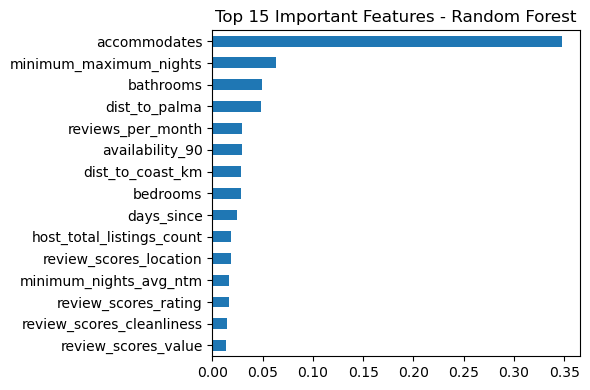

In [59]:
rf_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
rf_top10 = rf_importance.sort_values(ascending=False).head(15)

rf_top10.plot(kind='barh', title="Top 15 Important Features - Random Forest", figsize=(6,4))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


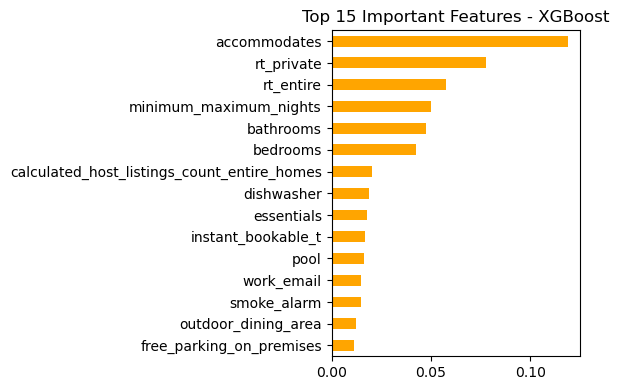

In [60]:
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train_encoded.columns)
xgb_top10 = xgb_importance.sort_values(ascending=False).head(15)

xgb_top10.plot(kind='barh', title="Top 15 Important Features - XGBoost", color="orange", figsize=(6,4))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Discussion:** feature importance of Random Forest vs. XGBoost
- Both models identify **accommodates** as the most important feature, confirming economic intuition: larger listings typically command higher prices.
- Random Forest highlights structural constraints (e.g. *minimum_maximum_nights*, *bathrooms*) and location (*dist_to_palma*) more than XGBoost. This is consistent with RF's tendency to use decorrelated trees to capture general variance across the dataset.
- In contrast, **XGBoost** places more weight on **room type dummies** (*rt_private*, *rt_entire*) and amenities (e.g. *dishwasher*, *pool*, *instant_bookable_t*), reflecting its strength in handling interactions and fitting residual variation. This is consistent with the sequential learning of boosting, which corrects previous model errors.
- Methodologically, RF provides robust general patterns (global interpretability), while boosting captures nuanced, potentially high-impact effects (local adaptivity). These differences support the lecture material: **RF decorrelates to reduce variance**, while **boosting adapts to errors**, often leading to a sharper focus on niche but relevant predictors such as specific amenities.

**Conclusion:** XGBoost uses richer feature interactions to extract predictive value from categorical and amenity variables, while Random Forest provides a more averaged, stable view driven by core numerical predictors. Depending on the need for performance versus generalisability, either model may be preferred.

# Part 2. Validity

# Part 2.A. Repeat Data Wrangling

In [61]:
mallorca_q4 = pd.read_csv('https://data.insideairbnb.com/spain/islas-baleares/mallorca/2024-12-14/data/listings.csv.gz', compression='gzip')
mallorca_q4.head(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,69998,https://www.airbnb.com/rooms/69998,20241214212418,2024-12-15,city scrape,COZY HIDEAWAY LOFT... MI AMOR...,A unique space in the 07001 district of the ol...,( soho-chic bohemian neighborhood of the city ...,https://a0.muscache.com/pictures/6d4007c1-f223...,353156,...,4.97,4.89,4.81,NaN,t,2,2,0,0,1.69
1,106833,https://www.airbnb.com/rooms/106833,20241214212418,2024-12-15,city scrape,Villa with a big pool in Mallorca,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,551974,...,4.92,4.52,4.63,ET/1961,f,1,1,0,0,0.18


In [62]:
# Remove dollar signs and commas from the price column and convert to float
mallorca_q4["price"] = mallorca_q4["price"].str.replace("$", "").str.replace(",", "").astype("float")

# Drop rows with missing prices
mallorca_q4 = mallorca_q4[~mallorca_q4.price.isna()].reset_index(drop=True)

# Convert text columns to binary indicators
text_columns_to_convert = ['description', 'neighborhood_overview', 'host_about']
for col in text_columns_to_convert:
    binary_col_name = f"has_{col}"
    mallorca_q4[binary_col_name] = mallorca_q4[col].notnull().astype(int)
mallorca_q4.drop(columns=text_columns_to_convert, inplace=True)

# Create dummy variables for specific columns
li_dummy_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
mallorca_q4 = pd.get_dummies(mallorca_q4, columns=li_dummy_columns, drop_first=True)

# Convert date columns to datetime and calculate days since
mallorca_q4['host_since'] = pd.to_datetime(mallorca_q4['host_since'], format='%Y-%m-%d')
mallorca_q4["days_since"] = pd.to_datetime(
    mallorca_q4["calendar_last_scraped"], format="%Y-%m-%d"
) - pd.to_datetime(mallorca_q4["first_review"], format="%Y-%m-%d")
mallorca_q4["days_since"] = [x.days if pd.notnull(x) else None for x in mallorca_q4["days_since"]]

# Convert percentage columns to float
mallorca_q4["host_response_rate"] = mallorca_q4["host_response_rate"].str.rstrip('%').astype("float") / 100
mallorca_q4["host_acceptance_rate"] = mallorca_q4["host_acceptance_rate"].str.rstrip('%').astype("float") / 100

# Simplify property types
mallorca_q4["property_type"] = mallorca_q4["property_type"].map(property_type_map).fillna("Other")
mallorca_q4["property_type"] = mallorca_q4["property_type"].astype("category")

# Simplify room types
room_type_map = {
    "Entire home/apt": "rt_entire",
    "Private room": "rt_private",
    "Hotel room": "rt_hotel",
    "Shared room": "rt_shared"
}
mallorca_q4["room_type_clean"] = mallorca_q4["room_type"].map(room_type_map)
room_dummies = pd.get_dummies(mallorca_q4["room_type_clean"])
mallorca_q4 = pd.concat([mallorca_q4, room_dummies], axis=1)

# Distance variables
mallorca = ox.geocode_to_gdf("Mallorca, Spain")
geometry = [Point(xy) for xy in zip(mallorca_q4['longitude'], mallorca_q4['latitude'])]
mallorca_q4 = gpd.GeoDataFrame(mallorca_q4, geometry=geometry, crs="EPSG:4326")
mallorca_q4 = mallorca_q4.to_crs(epsg=3857)
mallorca = mallorca.to_crs(epsg=3857)
mallorca_boundary = mallorca.geometry.iloc[0].boundary
mallorca_q4['dist_to_coast_km'] = mallorca_q4.geometry.distance(mallorca_boundary) / 1000  # meters to km
mallorca_q4['dist_to_coast_km'].describe()

# Coordinates of Palma city center
palma_coords = (39.5696, 2.6502)
mallorca_q4['dist_to_palma'] = mallorca_q4.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), palma_coords).kilometers,
    axis=1
)
mallorca_q4 = mallorca_q4.drop(columns=['latitude', 'longitude'])

# Drop irrelevant columns
li_drop_columns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'license', 'source', 'name',
    'host_id', 'host_url', 'picture_url', 'host_location', 'host_thumbnail_url', 
    'host_picture_url', 'host_neighbourhood', 'host_name', 'host_response_time',
    'neighbourhood', 'property_type', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
    'bathrooms_text', 'calendar_updated', 'has_availability', 'geometry', 'calendar_last_scraped',
    'first_review', 'last_review', 'room_type_clean', 'host_since', 
    'availability_30', 'availability_60', 'availability_365', "number_of_reviews", "number_of_reviews_ltm", 
    "number_of_reviews_l30d"]
mallorca_q4 = mallorca_q4.drop(columns=li_drop_columns)

# Drop rows with missing values in specific columns
cols_to_check = [
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'review_scores_rating', 'reviews_per_month'
]
mallorca_q4 = mallorca_q4.dropna(subset=cols_to_check).reset_index(drop=True)

# Drop rows with minor missing values (less than 5%)
na_ratios = mallorca_q4.isnull().mean()
minor_missing = na_ratios[(na_ratios > 0) & (na_ratios < 0.05)].index
mallorca_q4.dropna(subset=minor_missing, inplace=True)

# Remove top 10% most expensive listings
price_cutoff = mallorca_q4["price"].quantile(0.90)
mallorca_q4 = mallorca_q4[mallorca_q4["price"] <= price_cutoff].reset_index(drop=True)

# Impute missing values with mode
for col in mallorca_q4.columns:
    if mallorca_q4[col].isnull().any():
        mode_value = mallorca_q4[col].mode()[0]
        mallorca_q4[col].fillna(mode_value, inplace=True)

# Final dataset shape
mallorca_q4.shape

(10869, 46)

In [63]:
# convert stringified lists into actual lists
df_tmp = mallorca_q4.copy()
df_tmp['host_verifications'] = df_tmp['host_verifications'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else [])
)

# unique verification methods
all_verifications = set()
for items in df_tmp['host_verifications']:
    all_verifications.update(items)

# dummy columns for each verification method
for method in all_verifications:
    df_tmp[method] = df_tmp['host_verifications'].apply(lambda x: int(method in x))

df_tmp.drop(columns=['host_verifications'], inplace=True)
mallorca_q4 = df_tmp
mallorca_q4.shape

(10869, 48)

In [64]:
import ast
from collections import Counter
import re

df_tmp = mallorca_q4.copy()

# convert stringified lists into actual lists
for col in ['amenities']:
    df_tmp[col] = df_tmp[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else [])
    )

# count frequency of all values across amenities
counter = Counter()
for col in ['amenities']:
    for items in df_tmp[col]:
        counter.update(items)

# top 50 most common values
top_values = set([item for item, _ in counter.most_common(50)])

# function to clean names: lowercase, replace spaces with underscores, remove special chars
def clean_name(name):
    name = name.lower().strip()
    name = re.sub(r"[^\w\s]", "", name)  # remove punctuation
    name = re.sub(r"\s+", "_", name)     # replace spaces with underscores
    return name

# dummy columns for each of the top 50 values, using cleaned names
for value in top_values:
    cleaned_col_name = clean_name(value)
    df_tmp[cleaned_col_name] = df_tmp[['amenities']].apply(
        lambda row: int(any(value in entry for entry in row)), axis=1
    )

# drop original amenities column
df_tmp.drop(columns=['amenities'], inplace=True)
mallorca_q4 = df_tmp
mallorca_q4.shape


(10869, 97)

In [65]:
# Prepare the new dataset for modeling
y_new = mallorca_q4["price"].copy()
X_new = mallorca_q4.drop(columns=["price"]).copy()

# Convert binary features to categorical (for boosting models)
binary_features_new = [col for col in X_new.columns if X_new[col].nunique() == 2]
for col in binary_features_new:
    X_new[col] = X_new[col].astype("category")

# Standardized version (for OLS, LASSO, etc.)
X_new_scaled = scaler.fit_transform(X_new)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.2, random_state=30032025
)

X_train_new_linear, X_test_new_linear, y_train_new_linear, y_test_new_linear = train_test_split(
    X_new_scaled, y_new, test_size=0.2, random_state=30032025
)

# Evaluate OLS models
cv_list_new = []
for model in model_equations:
    start = time.time()
    result = ols_crossvalidator("price" + model, mallorca_q4, n_folds)
    end = time.time()
    result["Time"] = round(end - start, 2)
    cv_list_new.append(result)

# Evaluate Lasso
y_new_lasso, X_new_lasso = patsy.dmatrices("price" + vars_model_7, mallorca_q4)
X_new_lasso_featnames = X_new_lasso.design_info.column_names
X_new_lasso = scaler.fit_transform(X_new_lasso)

start = time.time()
lasso_fit_new = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X_new_lasso, y_new_lasso)
end = time.time()
lasso_time_new = round(end - start, 2)

lasso_r2_new = lasso_fit_new.score(X_new_lasso, y_new_lasso)
lasso_rmse_new = rmse_lambda_folds.loc[lasso_fit_new.alpha_].values[0]
notnull_lasso_coefs_new = (
    pd.DataFrame(lasso_fit_new.coef_, index=X_new_lasso_featnames, columns=["coefficient"])
    .loc[lambda x: x["coefficient"].round(3) != 0]
    .round(3)
)

# Evaluate Random Forest
rf_model_new = RandomForestRegressor(n_estimators=100, random_state=42)

start = time.time()
rf_model_new.fit(X_train_new, y_train_new)
end = time.time()
rf_time_new = round(end - start, 2)

rf_predictions_new = rf_model_new.predict(X_test_new)
rf_rmse_new = np.sqrt(mean_squared_error(y_test_new, rf_predictions_new))
rf_r2_new = rf_model_new.score(X_test_new, y_test_new)

# Evaluate XGBoost
X_train_new_encoded = X_train_new.copy()
X_test_new_encoded = X_test_new.copy()

for col in X_train_new_encoded.select_dtypes(include=["category"]).columns:
    X_train_new_encoded[col] = X_train_new_encoded[col].cat.codes
    X_test_new_encoded[col] = X_test_new_encoded[col].cat.codes

xgb_model_new = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

start = time.time()
xgb_model_new.fit(X_train_new_encoded, y_train_new)
end = time.time()
xgb_time_new = round(end - start, 2)

xgb_predictions_new = xgb_model_new.predict(X_test_new_encoded)
xgb_rmse_new = np.sqrt(mean_squared_error(y_test_new, xgb_predictions_new))
xgb_r2_new = xgb_model_new.score(X_test_new_encoded, y_test_new)

# Create the compare_model_fits table
compare_model_fits_new = (
    pd.DataFrame(cv_list_new)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(cv_list_new))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
        Time=lambda x: x["Time"]
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE", "Time"])
)

# Add Lasso results
compare_model_fits_new.loc[len(compare_model_fits_new)] = {
    "Model": "Lasso",
    "Coefficients": notnull_lasso_coefs_new.shape[0],
    "R-squared": round(lasso_r2_new, 2),
    "BIC": None,
    "Training RMSE": None,
    "Test RMSE": round(lasso_rmse_new, 2),
    "Time": lasso_time_new
}

# Add Random Forest results
compare_model_fits_new.loc[len(compare_model_fits_new)] = {
    "Model": "Random Forest",
    "Coefficients": X_train_new.shape[1],
    "R-squared": round(rf_r2_new, 2),
    "BIC": "N/A",
    "Training RMSE": "N/A",
    "Test RMSE": round(rf_rmse_new, 2),
    "Time": rf_time_new
}

# Add XGBoost results
compare_model_fits_new.loc[len(compare_model_fits_new)] = {
    "Model": "XGBoost",
    "Coefficients": X_train_new.shape[1],
    "R-squared": round(xgb_r2_new, 2),
    "BIC": "N/A",
    "Training RMSE": "N/A",
    "Test RMSE": round(xgb_rmse_new, 2),
    "Time": xgb_time_new
}

compare_model_fits_new

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE,Time
0,M1,2,0.32,128657,89.88,89.99,0.13
1,M2,8,0.35,128121,87.45,87.78,0.43
2,M3,16,0.37,127988,86.58,87.29,0.77
3,M4,19,0.37,127946,86.28,87.24,0.65
4,M5,36,0.42,127136,82.47,83.96,0.80
5,M6,46,0.44,126928,81.28,84.80,0.99
6,M7,96,0.48,126678,78.57,82.94,2.68
7,Lasso,70,0.47,None,None,73.42,0.34
8,Random Forest,96,0.56,N/A,N/A,72.35,57.47
9,XGBoost,96,0.60,N/A,N/A,68.99,2.97


## Part 2.2. Another city - Barcelona (q2)

In [85]:
barcelona_q2 = pd.read_csv('https://data.insideairbnb.com/spain/catalonia/barcelona/2024-06-15/data/listings.csv.gz', compression='gzip')

# Replace dollar signs and commas in the price column and convert to float
barcelona_q2["price"] = barcelona_q2["price"].astype(str).str.replace("$", "").str.replace(",", "").astype("float")

# Drop rows with missing prices
barcelona_q2 = barcelona_q2[~barcelona_q2.price.isna()].reset_index(drop=True)

# Convert text columns to binary indicators
text_columns_to_convert = ['description', 'neighborhood_overview', 'host_about']
for col in text_columns_to_convert:
    binary_col_name = f"has_{col}"
    barcelona_q2[binary_col_name] = barcelona_q2[col].notnull().astype(int)
barcelona_q2.drop(columns=text_columns_to_convert, inplace=True)

# Create dummy variables for specific columns
li_dummy_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
barcelona_q2 = pd.get_dummies(barcelona_q2, columns=li_dummy_columns, drop_first=True)

# Convert host_since to datetime and calculate days since first review
barcelona_q2['host_since'] = pd.to_datetime(barcelona_q2['host_since'], format='%Y-%m-%d')
barcelona_q2["days_since"] = pd.to_datetime(
    barcelona_q2["calendar_last_scraped"], format="%Y-%m-%d"
) - pd.to_datetime(barcelona_q2["first_review"], format="%Y-%m-%d")
barcelona_q2["days_since"] = [x.days if pd.notnull(x) else None for x in barcelona_q2["days_since"]]

# Convert host response and acceptance rates to float
barcelona_q2["host_response_rate"] = barcelona_q2["host_response_rate"].str.rstrip('%').astype("float") / 100
barcelona_q2["host_acceptance_rate"] = barcelona_q2["host_acceptance_rate"].str.rstrip('%').astype("float") / 100

barcelona_q2["room_type"] = barcelona_q2["room_type"].astype("category")

# Drop irrelevant columns
li_drop_columns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'license', 'source', 'name',
    'host_id', 'host_url', 'picture_url', 'host_location', 'host_thumbnail_url', 
    'host_picture_url', 'host_neighbourhood', 'host_name', 'host_response_time',
    'neighbourhood', 'property_type', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
    'bathrooms_text', 'calendar_updated', 'has_availability', 'geometry', 'calendar_last_scraped',
    'first_review', 'last_review', 'room_type2', 'room_type_clean', 'host_since', 
    'availability_30', 'availability_60', 'availability_365', "number_of_reviews", "number_of_reviews_ltm", 
    "number_of_reviews_l30d"]
# Drop only the columns that exist in the DataFrame
columns_to_drop = [col for col in li_drop_columns if col in barcelona_q2.columns]
barcelona_q2 = barcelona_q2.drop(columns=columns_to_drop)

# Drop rows with missing values in specific columns
cols_to_check = [
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'review_scores_rating', 'reviews_per_month'
]
barcelona_q2 = barcelona_q2.dropna(subset=cols_to_check).reset_index(drop=True)

# Drop rows with minor missing values (<5%)
na_ratios = barcelona_q2.isnull().mean()
minor_missing = na_ratios[(na_ratios > 0) & (na_ratios < 0.05)].index
barcelona_q2.dropna(subset=minor_missing, inplace=True)

# Remove top 10% most expensive listings
price_cutoff = barcelona_q2["price"].quantile(0.90)
barcelona_q2 = barcelona_q2[barcelona_q2["price"] <= price_cutoff].reset_index(drop=True)

# Impute missing values with mode
for col in barcelona_q2.columns:
    if barcelona_q2[col].isnull().any():
        mode_value = barcelona_q2[col].mode()[0]
        barcelona_q2[col].fillna(mode_value, inplace=True)

# Final shape of the dataset
barcelona_q2.shape

(10315, 42)

In [86]:
# convert stringified lists into actual lists
df_tmp = barcelona_q2.copy()
df_tmp['host_verifications'] = df_tmp['host_verifications'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else [])
)

# unique verification methods
all_verifications = set()
for items in df_tmp['host_verifications']:
    all_verifications.update(items)

# dummy columns for each verification method
for method in all_verifications:
    df_tmp[method] = df_tmp['host_verifications'].apply(lambda x: int(method in x))

df_tmp.drop(columns=['host_verifications'], inplace=True)
barcelona_q2 = df_tmp
barcelona_q2.shape

(10315, 44)

In [87]:
import ast
from collections import Counter
import re

df_tmp = barcelona_q2.copy()

# convert stringified lists into actual lists
for col in ['amenities']:
    df_tmp[col] = df_tmp[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else [])
    )

# count frequency of all values across amenities
counter = Counter()
for col in ['amenities']:
    for items in df_tmp[col]:
        counter.update(items)

# top 50 most common values
top_values = set([item for item, _ in counter.most_common(50)])

# function to clean names: lowercase, replace spaces with underscores, remove special chars
def clean_name(name):
    name = name.lower().strip()
    name = re.sub(r"[^\w\s]", "", name)  # remove punctuation
    name = re.sub(r"\s+", "_", name)     # replace spaces with underscores
    return name

# dummy columns for each of the top 50 values, using cleaned names
for value in top_values:
    cleaned_col_name = clean_name(value)
    df_tmp[cleaned_col_name] = df_tmp[['amenities']].apply(
        lambda row: int(any(value in entry for entry in row)), axis=1
    )

# drop original amenities column
df_tmp.drop(columns=['amenities'], inplace=True)
barcelona_q2 = df_tmp
barcelona_q2.shape


(10315, 93)

In [91]:
shared_vars = set(data.columns).intersection(set(barcelona_q2.columns))


In [92]:
filtered_model_equations = []

for model_formula in model_equations:
    target, features = model_formula.split("~")
    feature_list = [f.strip() for f in features.split("+")]
    valid_features = [f for f in feature_list if f in shared_vars]
    new_formula = target + "~ " + " + ".join(valid_features)
    filtered_model_equations.append(new_formula)


In [93]:
cv_list_new = []
for model in filtered_model_equations:
    start = time.time()
    result = ols_crossvalidator("price" + model[model.find("~"):], barcelona_q2, n_folds)
    end = time.time()
    result["Time"] = round(end - start, 2)
    cv_list_new.append(result)


Model performance was consistently better on the Mallorca Q2 dataset, with higher R-2 and lower test RMSE across all models, especially for tree-based approaches. This suggests that Q2 prices were more predictable, likely due to less seasonal variation or clearer patterns in guest behavior.